# データを読み込む

Data 2024とData2025の全エクセルファイルをpandasに読み込み。

In [63]:
import pandas as pd

# Excelファイルのパス
file_path = "./Data_toyama/J2-Data.xlsx"  # 適宜変更

# すべてのシートをヘッダーなしで読み込み
sheet_dfs_raw = pd.read_excel(file_path, sheet_name=None, header=None)

# 整形されたデータを格納する辞書
cleaned_tables = {}

# ヘッダー処理はそのまま
for sheet_name, df_raw in sheet_dfs_raw.items():
    header = df_raw.iloc[0].tolist()
    df_data = df_raw.iloc[1:].reset_index(drop=True)

    records = []

    # League average（2行目）
    league_avg = [df_data.iloc[0, 0]] + df_data.iloc[0, 1:].tolist()
    records.append(league_avg)

    # 残りは 2行ずつ（数値行 → チーム名行）
    for i in range(1, len(df_data) - 1, 2):
        team_name = df_data.iloc[i + 1, 0]  # チーム名
        values = df_data.iloc[i, 1:].tolist()  # 数値（1列目は #UNKNOWN! なので除外）
        records.append([team_name] + values)

    # DataFrame 化
    df_cleaned = pd.DataFrame(records, columns=header)
    cleaned_tables[sheet_name] = df_cleaned

# 例：PPDA against を表示
cleaned_tables["xGA"]

,Team,xGA,Goals conceded,xG per shot against
0,League average,18.95,17.8,0.110
1,Blaublitz Akita,25.79,28.0,0.134
2,Montedio Yamagata,23.86,18.0,0.124
3,Júbilo Iwata,23.12,21.0,0.131
4,Roasso Kumamoto,21.92,17.0,0.126
5,Consadole Sapporo,20.92,25.0,0.122
6,Fujieda MYFC,20.91,24.0,0.133
7,Kataller Toyama,20.83,15.0,0.116
8,Ventforet Kofu,19.52,15.0,0.122
9,V-Varen Nagasaki,19.39,25.0,0.128


### リーグ内でのZScore


In [34]:
import pandas as pd
from scipy.stats import zscore

# カターレ富山のZスコアを収集
toyama_zscores = []

for sheet_name, df in cleaned_tables.items():
    if "Team" not in df.columns:
        continue

    df_numeric = df.copy()
    df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')
    df_numeric["Team"] = df["Team"]

    if not any(df_numeric["Team"] == "Kataller Toyama"):
        continue

    # Zスコア計算
    df_z = df_numeric.set_index("Team").apply(zscore, nan_policy='omit')

    if "Kataller Toyama" in df_z.index:
        toyama_z = df_z.loc["Kataller Toyama"]
        for metric, z in toyama_z.dropna().items():
            toyama_zscores.append({
                "Sheet": sheet_name,
                "Metric": metric,
                "Z-Score": z
            })

# DataFrame化して上位10件を抽出
df_zscore = pd.DataFrame(toyama_zscores)
df_zscore["Abs Z-Score"] = df_zscore["Z-Score"].abs()
df_top10 = df_zscore.sort_values("Abs Z-Score", ascending=False).head(10)

# 表示
df_top10[["Sheet", "Metric", "Z-Score"]].reset_index(drop=True)


,Sheet,Metric,Z-Score
0,Through passes,Per 90 mins,1.574382
1,Shots blocked,Percentage of blocked shots,1.561840
2,Through passes,Total,1.525303
3,Defensive duels,% success,-1.481720
4,Goal,Head,-1.476743
5,PPDA,PPDA,1.425291
6,Goal,From corners,-1.344061
7,Defensive duels,Per 90 mins,1.333581
8,Cross,From right flank,-1.272614
9,Shots,% on target,-1.246402


### xGランキング

C:\Users\arita\AppData\Local\Temp\ipykernel_21416\4288282165.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="Team", y="xG", palette=palette, edgecolor="black")


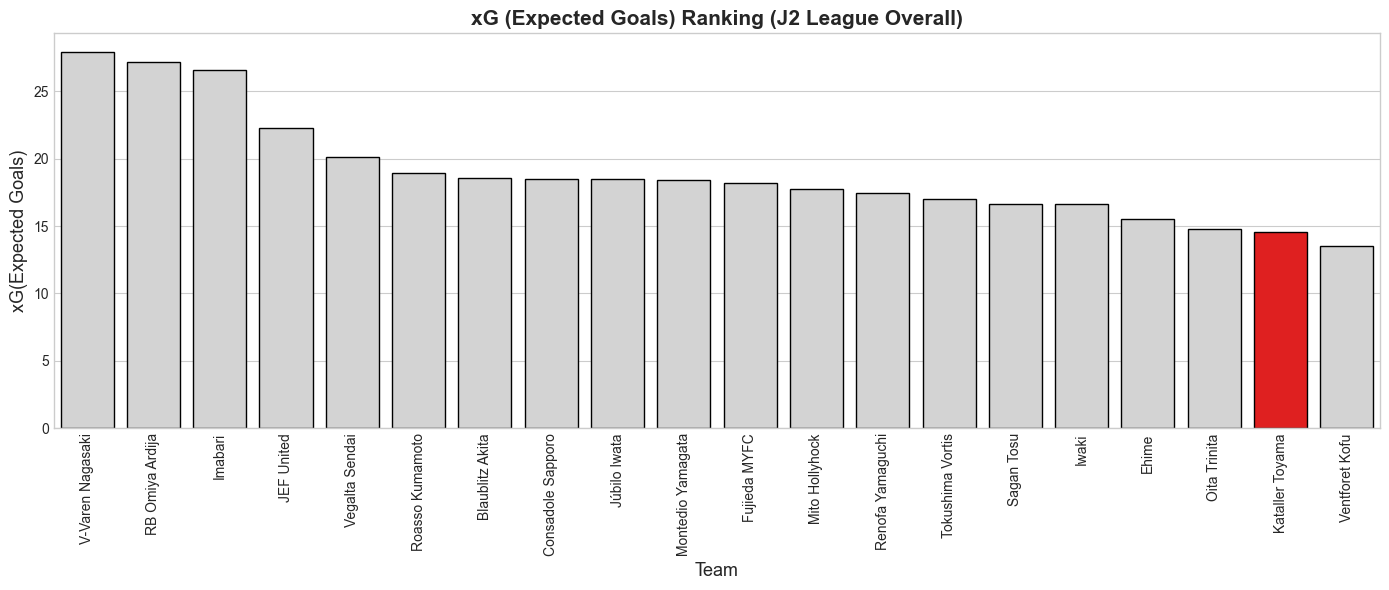

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# データ取得と整形
df_xg = cleaned_tables.get("xG", pd.DataFrame()).copy()

# カラム名の正規化
df_xg.columns = [col.strip() for col in df_xg.columns]
df_xg = df_xg.rename(columns={" xG": "xG"})  # NBSP除去

# 不要行の除外
df_xg = df_xg[df_xg["Team"].notna() & (df_xg["Team"] != "League average")]

# 数値変換
df_xg["xG"] = pd.to_numeric(df_xg["xG"], errors="coerce")
df_xg["Goals"] = pd.to_numeric(df_xg["Goals"], errors="coerce")
df_plot = df_xg.dropna(subset=["xG", "Goals"])

# 並べ替え
df_plot = df_plot.sort_values("xG", ascending=False)

# 富山を強調色で処理
palette = ["red" if team == "Kataller Toyama" else "lightgray" for team in df_plot["Team"]]

# プロット
plt.figure(figsize=(14, 6))
sns.barplot(data=df_plot, x="Team", y="xG", palette=palette, edgecolor="black")

plt.xticks(rotation=90, fontsize=10)
plt.xlabel("Team", fontsize=13)
plt.ylabel("xG(Expected Goals)", fontsize=13)
plt.title("xG (Expected Goals) Ranking (J2 League Overall)", fontsize=15, fontweight="bold")
plt.tight_layout()
plt.show()


C:\Users\arita\AppData\Local\Temp\ipykernel_21416\2660490720.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted, x=x_col, y=y_col, palette=palette, edgecolor="black")


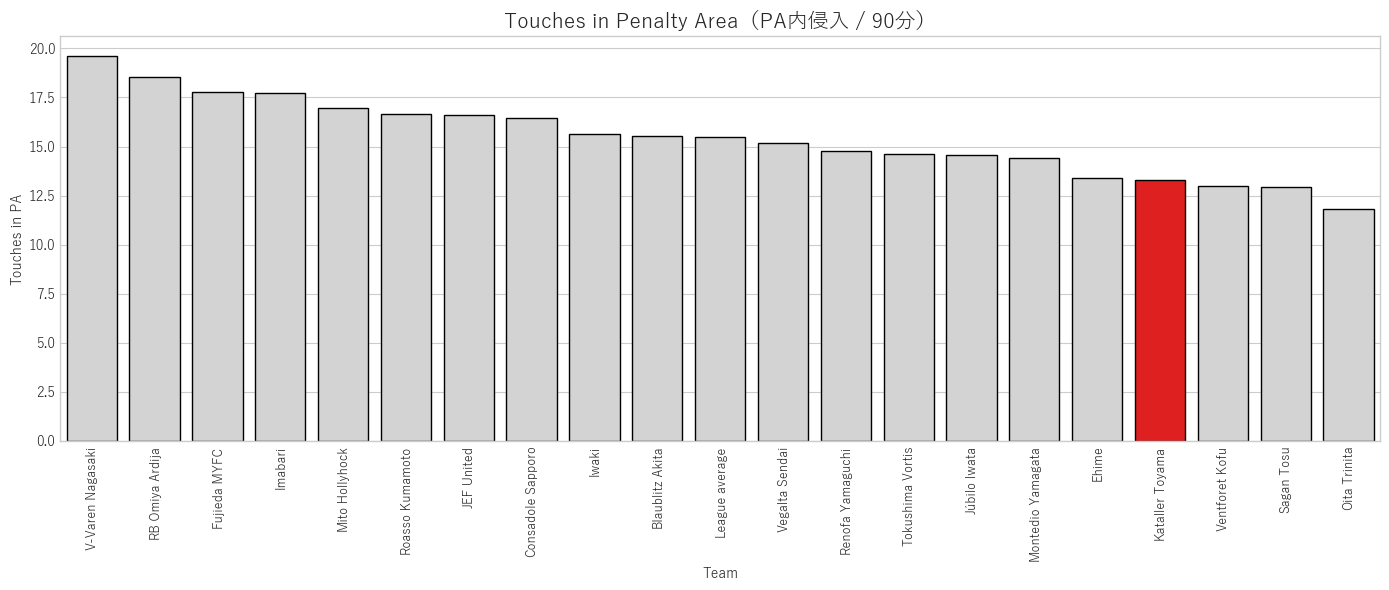

C:\Users\arita\AppData\Local\Temp\ipykernel_21416\2660490720.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted, x=x_col, y=y_col, palette=palette, edgecolor="black")


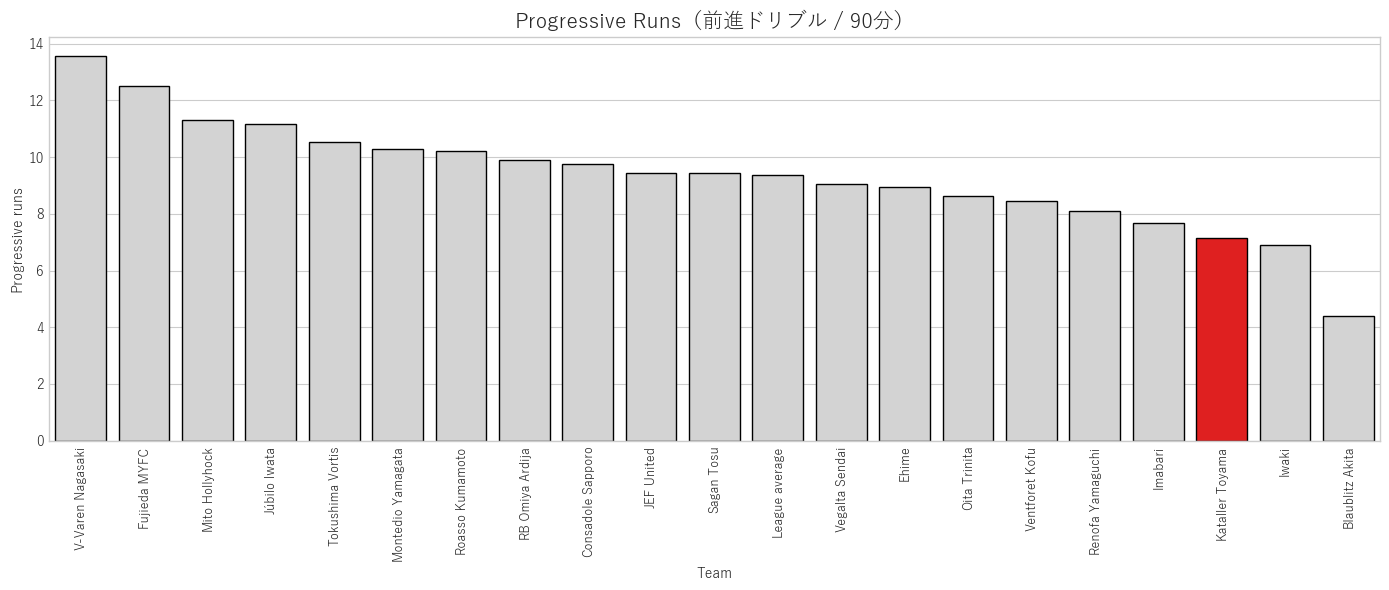

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 日本語フォントの設定
plt.rcParams['font.family'] = 'Yu Gothic'
# カラム整形
def clean_columns(df):
    return [col.strip().replace("\u00a0", " ") for col in df.columns]

# データ読み出し
df_touch = cleaned_tables.get("Touches in penalty area", pd.DataFrame()).copy()
df_prog = cleaned_tables.get("Progressive runs", pd.DataFrame()).copy()
df_touch.columns = clean_columns(df_touch)
df_prog.columns = clean_columns(df_prog)

# 整形
df_touch = df_touch[["Team", "Per 90 mins"]].rename(columns={"Per 90 mins": "Touches in PA"})
df_prog = df_prog[["Team", "Per 90 mins"]].rename(columns={"Per 90 mins": "Progressive runs"})
df_attack = pd.merge(df_touch, df_prog, on="Team", how="inner").dropna()

# グラフ描画関数
def plot_bar(df, x_col, y_col, title):
    df_sorted = df.sort_values(y_col, ascending=False).reset_index(drop=True)
    palette = ["red" if team == "Kataller Toyama" else "lightgray" for team in df_sorted[x_col]]

    plt.figure(figsize=(14, 6))
    sns.barplot(data=df_sorted, x=x_col, y=y_col, palette=palette, edgecolor="black")
    plt.xticks(rotation=90, fontsize=9)
    plt.title(title, fontsize=15)
    plt.tight_layout()
    plt.show()

# 描画
plot_bar(df_attack, "Team", "Touches in PA", "Touches in Penalty Area（PA内侵入 / 90分）")
plot_bar(df_attack, "Team", "Progressive runs", "Progressive Runs（前進ドリブル / 90分）")


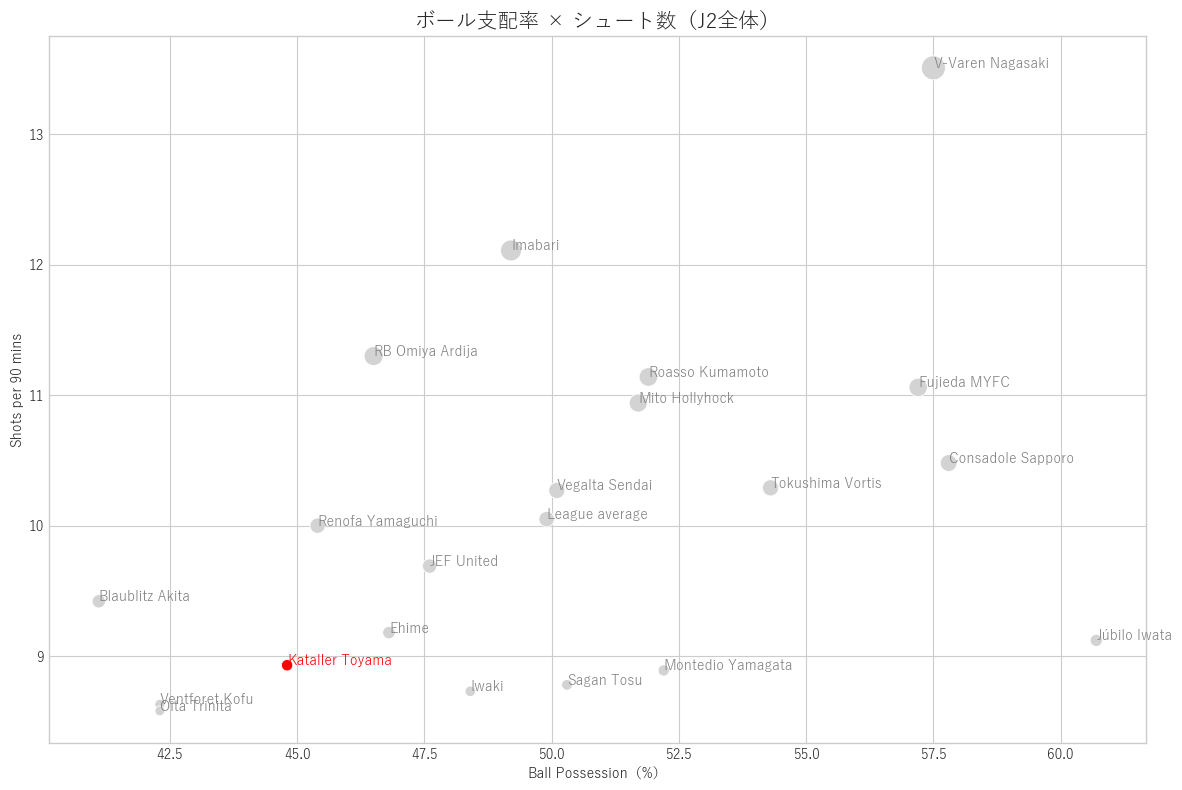

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Yu Gothic'  # 日本語対応

# Possession データ取得と整形
df_poss = cleaned_tables.get("Possession", pd.DataFrame()).copy()
df_poss.columns = [col.strip().replace("\u00a0", " ") for col in df_poss.columns]
df_poss = df_poss[["Team", "Ball possession"]].rename(columns={"Ball possession": "Possession"})

# Shots データ取得と整形
df_shots = cleaned_tables.get("Shots", pd.DataFrame()).copy()
df_shots.columns = [col.strip().replace("\u00a0", " ") for col in df_shots.columns]
df_shots = df_shots[["Team", "Per 90 mins"]].rename(columns={"Per 90 mins": "Shots"})

# 型合わせ
df_poss["Team"] = df_poss["Team"].astype(str)
df_shots["Team"] = df_shots["Team"].astype(str)

# マージ
df_bubble = pd.merge(df_poss, df_shots, on="Team").dropna()

# バブルチャート表示
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_bubble, x="Possession", y="Shots", size="Shots",
                hue=(df_bubble["Team"] == "Kataller Toyama"),
                sizes=(50, 300), palette={True: "red", False: "lightgray"}, legend=False)

# 全チーム名をプロット（富山は赤、それ以外はグレー）
for _, row in df_bubble.iterrows():
    color = "red" if row["Team"] == "Kataller Toyama" else "gray"
    plt.text(row["Possession"], row["Shots"], row["Team"], fontsize=10, color=color)

plt.xlabel("Ball Possession（%）")
plt.ylabel("Shots per 90 mins")
plt.title("ボール支配率 × シュート数（J2全体）", fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.show()


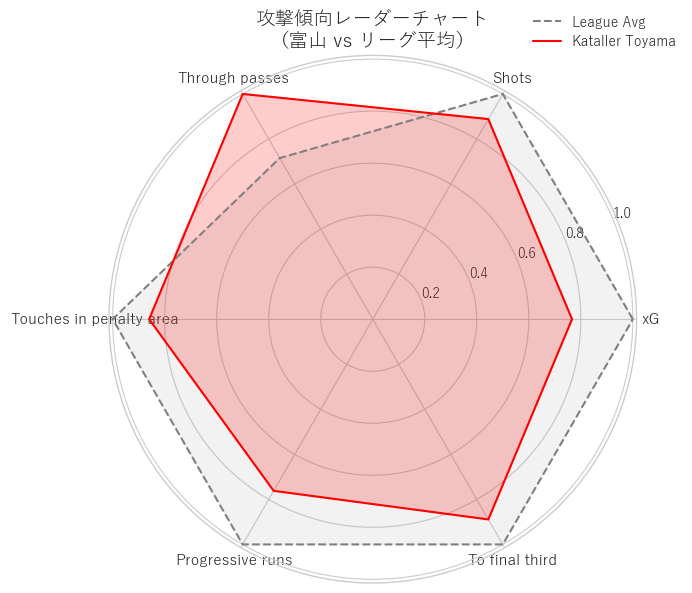

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 使用する攻撃指標
indicators = {
    "xG": "xG",
    "Shots": "Per 90 mins",
    "Through passes": "Per 90 mins",
    "Touches in penalty area": "Per 90 mins",
    "Progressive runs": "Per 90 mins",
    "To final third":"Per 90 mins"
}

team_name = "Kataller Toyama"
values_toyama = []
values_avg = []

for sheet, col in indicators.items():
    df = cleaned_tables.get(sheet, pd.DataFrame()).copy()
    df.columns = [c.strip().replace("\u00a0", " ") for c in df.columns]
    val = df.loc[df["Team"] == team_name, col].values[0]
    avg = df.loc[df["Team"] == "League average", col].values[0]
    values_toyama.append(float(val))
    values_avg.append(float(avg))

# 正規化（0〜1スケール）
values_toyama = np.array(values_toyama)
values_avg = np.array(values_avg)
max_vals = np.maximum(values_toyama, values_avg)
values_toyama_scaled = values_toyama / max_vals
values_avg_scaled = values_avg / max_vals

# レーダーチャート用のラベルと角度を設定
labels = list(indicators.keys())
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()

# 最初の角度を最後に追加して円を閉じる
angles.append(angles[0])

# 補完（レーダーチャート用に一周させる）
values_toyama_scaled = np.append(values_toyama_scaled, values_toyama_scaled[0])
values_avg_scaled = np.append(values_avg_scaled, values_avg_scaled[0])

# 描画
plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)
ax.plot(angles, values_avg_scaled, label='League Avg', color='gray', linestyle='--')
ax.fill(angles, values_avg_scaled, color='gray', alpha=0.1)

ax.plot(angles, values_toyama_scaled, label=team_name, color='red')
ax.fill(angles, values_toyama_scaled, color='red', alpha=0.2)

# ラベル表示の角度は指標の数だけ設定
ax.set_xticks(angles[:-1])  # 最後の角度（重複した最初の角度）を除外
ax.set_xticklabels(labels, fontsize=11)
ax.set_title("攻撃傾向レーダーチャート\n（富山 vs リーグ平均）", fontsize=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.tight_layout()
plt.show()

# 守備面

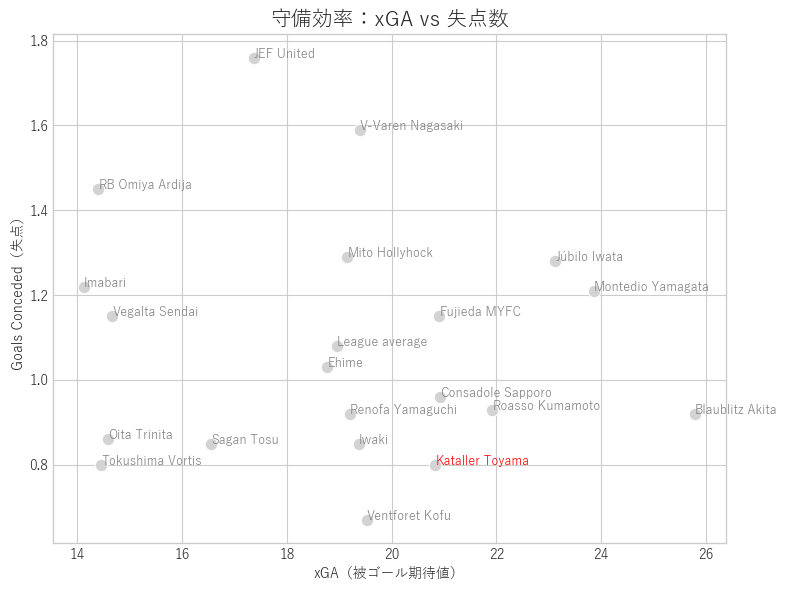

In [69]:
df_xga = cleaned_tables.get("xGA", pd.DataFrame()).copy()
df_goal = cleaned_tables.get("Goal", pd.DataFrame()).copy()

df_xga.columns = [c.strip().replace("\u00a0", " ") for c in df_xga.columns]
df_goal.columns = [c.strip().replace("\u00a0", " ") for c in df_goal.columns]

df_def = pd.merge(
    df_xga[["Team", "xGA"]],
    df_goal[["Team", "Per 90 mins"]].rename(columns={"Per 90 mins": "Goals conceded"}),
    on="Team", how="inner"
).dropna()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_def, x="xGA", y="Goals conceded", color="lightgray", s=80)

# 全チーム名表示
for _, row in df_def.iterrows():
    color = "red" if row["Team"] == "Kataller Toyama" else "gray"
    plt.text(row["xGA"], row["Goals conceded"], row["Team"], fontsize=9, color=color)

plt.xlabel("xGA（被ゴール期待値）")
plt.ylabel("Goals Conceded（失点）")
plt.title("守備効率：xGA vs 失点数", fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.show()


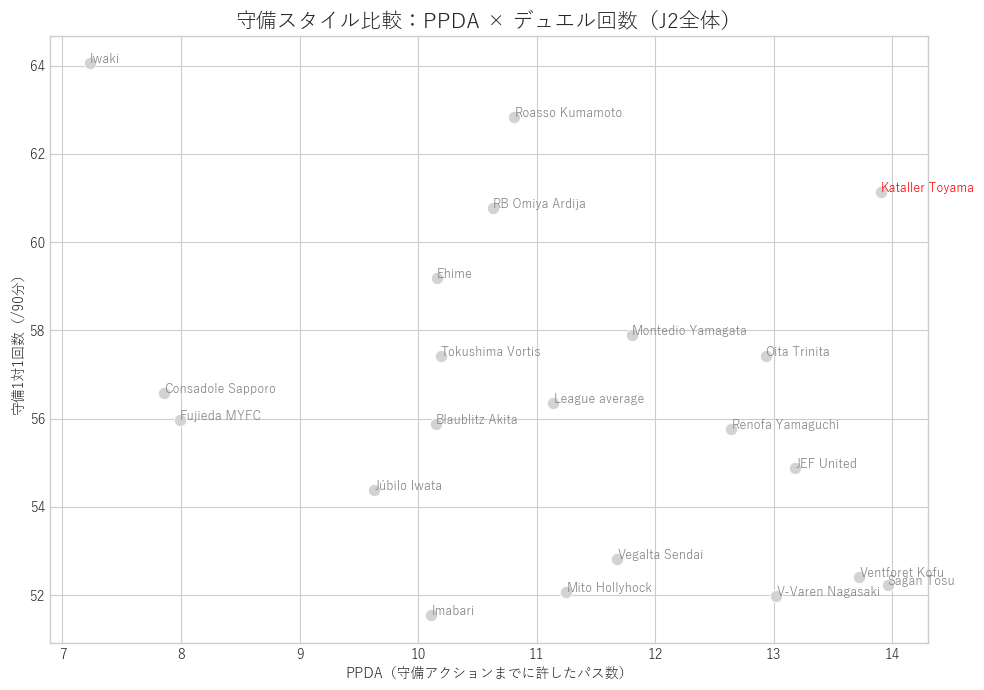

In [70]:
df_ppda = cleaned_tables.get("PPDA", pd.DataFrame()).copy()
df_duels = cleaned_tables.get("Defensive duels", pd.DataFrame()).copy()

df_ppda.columns = [c.strip().replace("\u00a0", " ") for c in df_ppda.columns]
df_duels.columns = [c.strip().replace("\u00a0", " ") for c in df_duels.columns]

df_defstyle = pd.merge(
    df_ppda[["Team", "PPDA"]],
    df_duels[["Team", "Per 90 mins"]].rename(columns={"Per 90 mins": "Def duels"}),
    on="Team", how="inner"
).dropna()

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_defstyle, x="PPDA", y="Def duels", color="lightgray", s=80)

# チーム名を全て表示
for _, row in df_defstyle.iterrows():
    color = "red" if row["Team"] == "Kataller Toyama" else "gray"
    plt.text(row["PPDA"], row["Def duels"], row["Team"], fontsize=9, color=color)

plt.xlabel("PPDA（守備アクションまでに許したパス数）")
plt.ylabel("守備1対1回数（/90分）")
plt.title("守備スタイル比較：PPDA × デュエル回数（J2全体）", fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.show()


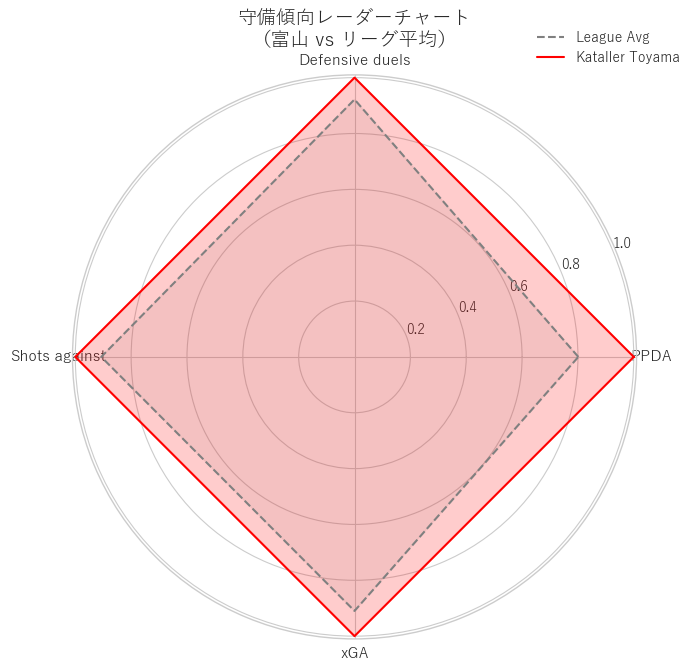

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 使用する攻撃指標
indicators = {
    "PPDA": "PPDA",
    "Defensive duels": "Per 90 mins",
    "Shots against": "Per 90 mins",
    "Shots blocked": "Per 90 mins",
    "Interception":"Per 90 mins",
    "xGA": "xGA",
}


team_name = "Kataller Toyama"
values_toyama = []
values_avg = []

for sheet, col in indicators.items():
    df = cleaned_tables.get(sheet, pd.DataFrame()).copy()
    df.columns = [c.strip().replace("\u00a0", " ") for c in df.columns]
    val = df.loc[df["Team"] == team_name, col].values[0]
    avg = df.loc[df["Team"] == "League average", col].values[0]
    values_toyama.append(float(val))
    values_avg.append(float(avg))

# 正規化（0〜1スケール）
values_toyama = np.array(values_toyama)
values_avg = np.array(values_avg)
max_vals = np.maximum(values_toyama, values_avg)
values_toyama_scaled = values_toyama / max_vals
values_avg_scaled = values_avg / max_vals

# レーダーチャート用のラベルと角度を設定
labels = list(indicators.keys())
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()

# 最初の角度を最後に追加して円を閉じる
angles.append(angles[0])

# 補完（レーダーチャート用に一周させる）
values_toyama_scaled = np.append(values_toyama_scaled, values_toyama_scaled[0])
values_avg_scaled = np.append(values_avg_scaled, values_avg_scaled[0])

# 描画
plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)
ax.plot(angles, values_avg_scaled, label='League Avg', color='gray', linestyle='--')
ax.fill(angles, values_avg_scaled, color='gray', alpha=0.1)

ax.plot(angles, values_toyama_scaled, label=team_name, color='red')
ax.fill(angles, values_toyama_scaled, color='red', alpha=0.2)

# ラベル表示の角度は指標の数だけ設定
ax.set_xticks(angles[:-1])  # 最後の角度（重複した最初の角度）を除外
ax.set_xticklabels(labels, fontsize=11)
ax.set_title("守備傾向レーダーチャート\n（富山 vs リーグ平均）", fontsize=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.tight_layout()
plt.show()